## Colour ranges
the HSV ranges like H from 0-179, S and V from 0-255

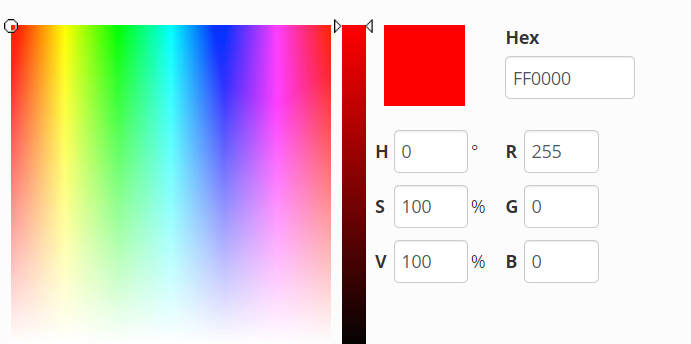

https://alloyui.com/examples/color-picker/hsv.html

## IMAGE SHAPE
(480, 640, 3)

-x ---------- +x

-y<br />
| <br />
| <br />
| <br />
| <br />
| <br />
| <br />/
+y

pixel count: 3148
centerpoints at: x: 441 y: 268
top left points are: x: 441 y: 268
distance from center: x: 121 y: 28


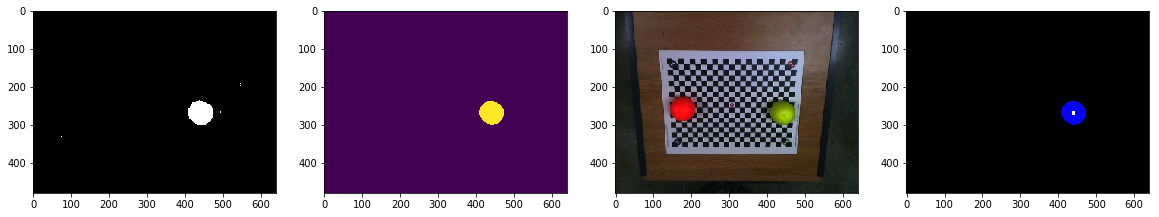

pixel count: 11077
centerpoints at: x: 357 y: 339
centerpoints at: x: 435 y: 269
centerpoints at: x: 432 y: 162
top left points are: x: 432 y: 162
distance from center: x: 112 y: -78


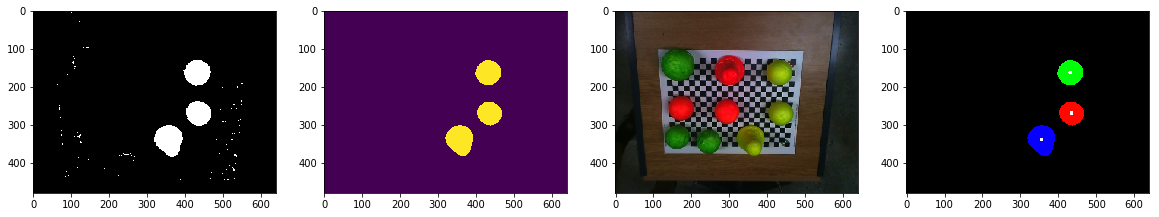

pixel count: 18412
centerpoints at: x: 218 y: 424
centerpoints at: x: 316 y: 332
centerpoints at: x: 313 y: 191
top left points are: x: 313 y: 191
distance from center: x: -7 y: -49


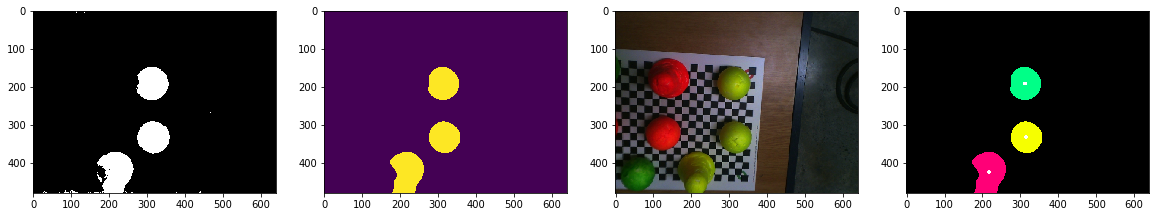

pixel count: 11522
centerpoints at: x: 374 y: 367
centerpoints at: x: 445 y: 289
centerpoints at: x: 431 y: 182
top left points are: x: 431 y: 182
distance from center: x: 111 y: -58


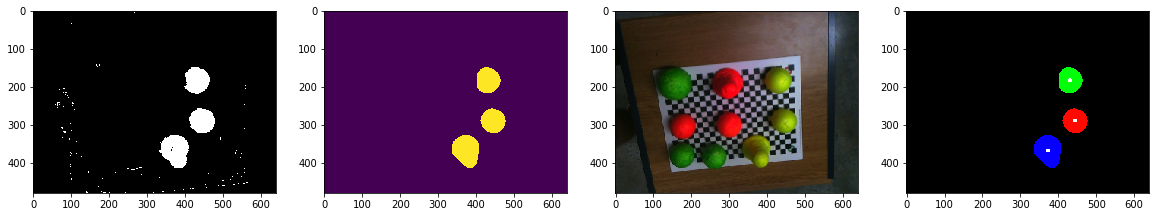

pixel count: 11051
centerpoints at: x: 369 y: 353
centerpoints at: x: 439 y: 277
centerpoints at: x: 426 y: 172
top left points are: x: 426 y: 172
distance from center: x: 106 y: -68


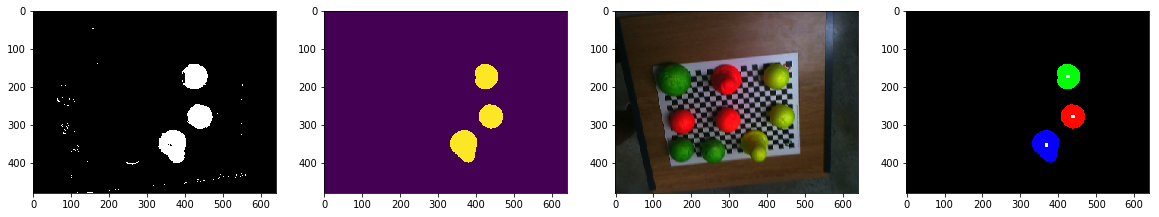

pixel count: 5520
centerpoints at: x: 327 y: 91
centerpoints at: x: 386 y: 23
top left points are: x: 327 y: 91
distance from center: x: 7 y: -149


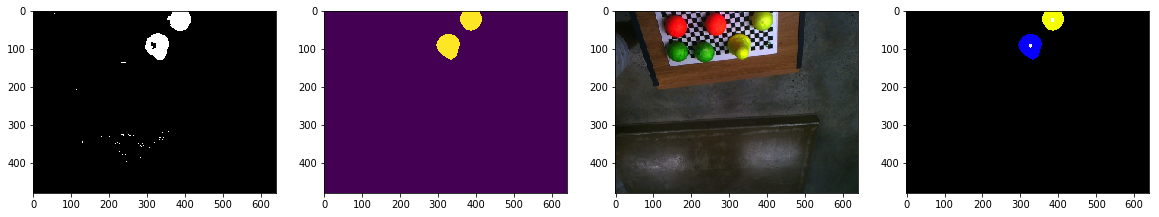

pixel count: 8133
centerpoints at: x: 375 y: 268
centerpoints at: x: 434 y: 202
centerpoints at: x: 425 y: 110
top left points are: x: 425 y: 110
distance from center: x: 105 y: -130


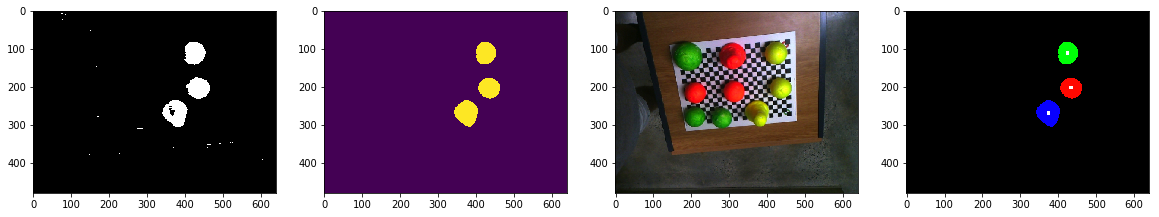

pixel count: 13740
centerpoints at: x: 464 y: 267
centerpoints at: x: 536 y: 174
centerpoints at: x: 510 y: 56
top left points are: x: 510 y: 56
distance from center: x: 190 y: -184


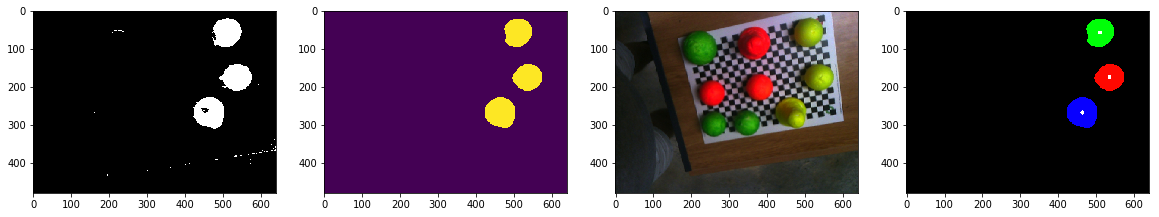

pixel count: 15109
centerpoints at: x: 315 y: 322
centerpoints at: x: 399 y: 226
centerpoints at: x: 382 y: 94
top left points are: x: 382 y: 94
distance from center: x: 62 y: -146


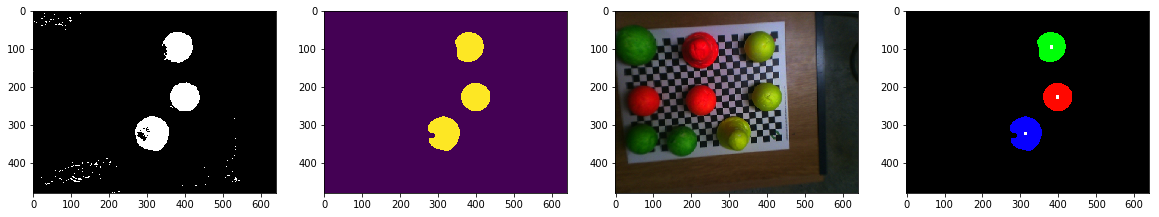

pixel count: 13504
centerpoints at: x: 503 y: 197
centerpoints at: x: 577 y: 74
top left points are: x: 503 y: 197
distance from center: x: 183 y: -43


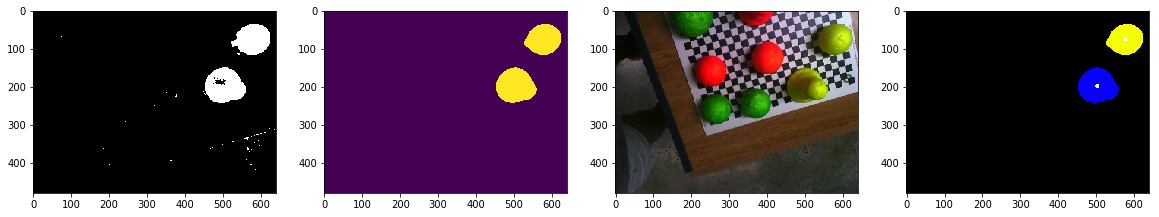

In [118]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np


detect_photos(colour='yellow')

In [116]:


def detect_photos(colour):

    files = glob.glob("Images/*")[:10]

    # two ranges because red stretchs over the Hue colour range
    
    ##RED
    lower_red_1 = (0,100,50)
    upper_red_1 = (5,255,255)

    lower_red_2 = (170,100,50)
    upper_red_2 = (180,255,255)
    
    ##GREEN
    lower_green = (45, 100, 50)
    upper_green = (65, 255, 255)
    
    ##YELLOW
    lower_yellow = (20, 100, 50)
    upper_yellow = (45, 255, 255)


    for f in files:
        # reading in image to RGB and HSV
        img_RGB = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
        img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
        
        if colour == 'red':

            # Create two masks
            mask1 = cv2.inRange(img_HSV, lower_red_1, upper_red_1)
            mask2 = cv2.inRange(img_HSV, lower_red_2, upper_red_2)

            # XOR masks
            mask = cv2.bitwise_xor(mask1, mask2)
        elif colour == 'green':
            mask = cv2.inRange(img_HSV, lower_green, upper_green)
        
        elif colour == 'yellow':
            mask = cv2.inRange(img_HSV, lower_yellow, upper_yellow)
            
        
        # bitwise and with image
        result = cv2.bitwise_and(img_HSV, img_HSV, mask=mask)


        # put median blur over the top
        median = cv2.medianBlur(mask,23)
        
        print("pixel count: " + str(cv2.countNonZero(median)))
        
        if cv2.countNonZero(median) < 2000:
            print("no more objects in scene of colour: " + colour)
            return None

        # find connected components
        ret, labels = cv2.connectedComponents(median)

        # Map component labels to hue val
        label_hue = np.uint8(179*labels/np.max(labels))
        blank_ch = 255*np.ones_like(label_hue)
        labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

        # cvt to BGR for display
        labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

        # set bg label to black
        labeled_img[label_hue==0] = 0

        #########################################################
        ## Finding Centers!
        ret,thresh = cv2.threshold(median,127,255,0)

        # find contours in the binary image
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        
        distance_min = 100000
        for c in contours:
            # calculate moments for each contour
            M = cv2.moments(c)

            # calculate x,y coordinate of center
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                cv2.circle(labeled_img, (cX, cY), 5, (255, 255, 255), -1)
                
                distance_new = np.sqrt(cX**2 + cY**2)
                if distance_new < distance_min:
                    distance_min = distance_new
                    X_top_left = cX
                    Y_top_left = cY
                
                print("centerpoints at: x: " + str(cX) + " y: " + str(cY))
        
        print("top left points are: x: " + str(X_top_left) + " y: " + str(Y_top_left))
        
        X_from_center = X_top_left - (640/2)
        Y_from_center = Y_top_left - (480/2)
        
        print("distance from center: x: " + str(X_from_center) + " y: " + str(Y_from_center))
        
        # print out figures
        figure = plt.figure(figsize=(20,20))
        plt.subplot(1, 4, 1)
        # mask
        plt.imshow(mask, cmap="gray")
        plt.subplot(1, 4, 2)
        # median blue
        plt.imshow(median)
        #original image
        plt.subplot(1, 4, 3)
        plt.imshow(img_RGB)
        # final 
        plt.subplot(1, 4, 4)
        plt.imshow(labeled_img)

        plt.show()
        
        return [X_from_center, Y_from_center]

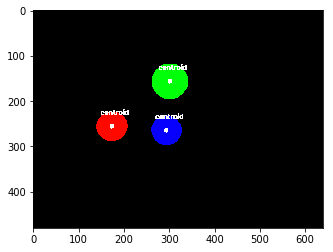

In [59]:
plt.imshow(labeled_img)

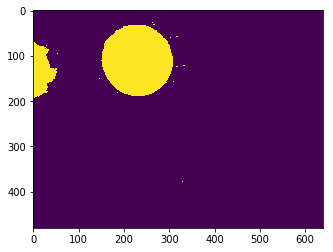

In [80]:
plt.imshow(img_RGB)
plt.show()

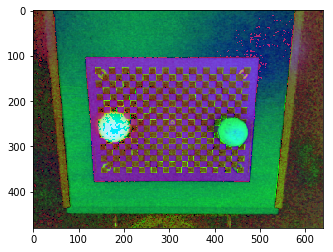

In [55]:
plt.imshow(img_HSV)
plt.show()

In [102]:
np.sqrt(4)

2.0

In [104]:
2**5

32

In [120]:
if None:
    print(1)